In [87]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import re
import processing as proc
import torch
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F



model_sentence_transform = SentenceTransformer('all-mpnet-base-v2')
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model_base = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

In [88]:
df = pd.read_json("./Data_Processing/Data/job_processed_data_main.json")

df.head(20)

,Job_Titles,Neutral,Positive,Negative,Prompt_Tokens,Response_Tokens,Total_Tokens,Neutral_Encodings,Positive_Encodings,Negative_Encodings,Neutral_Terminated,Neutral_Terminated_Encodings,Positive_Leading,Positive_Leading_Encodings,Negative_Leading,Negative_Leading_Encodings
0,Technical Support Representative,I am a Technical Support Representative,I am knowledgeable and skilled in providing te...,I may encounter difficult and frustrated custo...,62,29,91,"[0.052540335800000004, -0.0741394237, -0.02414...","[0.0398985222, -0.039076753000000006, -0.03879...","[0.0750338361, 0.055929131800000004, -0.034461...",I am a Technical Support Representative.,"[0.0467863977, -0.0582639724, -0.0304021016000...",I am knowledgeable and skilled in providing te...,"[0.0400350429, -0.0512237102, -0.0361330472000...",I may encounter difficult and frustrated custo...,"[0.06889098140000001, 0.053461976300000005, -0..."
1,A&H Underwriter,I am an A&H Underwriter,I have a great job as an A&H Underwriter.,I am not happy with my job as an A&H Underwriter.,65,35,100,"[-0.0183508322, 0.025549562600000002, -0.02162...","[-0.0315244012, 0.0867658779, -0.0072295303, -...","[-0.027420181800000002, 0.0644791871, -0.00949...",I am an A&H Underwriter .,"[-0.022203857100000002, 0.0287630353, -0.02035...",I have a great job as an A&H Underwriter,"[-0.0302970372, 0.0902502164, -0.0129407654, -...",I am not happy with my job as an A&H Underwriter,"[-0.026900822300000002, 0.0706868768, -0.01072..."
2,A&H Underwriting Manager,I am an A&H Underwriting Manager,I have a high-level position as an A&H Underwr...,"I am not just an entry-level employee, but I h...",65,44,109,"[-0.017012547700000002, 0.0080151027, -0.02787...","[-0.0027675340000000003, 0.068974562, -0.00189...","[-0.0194694344, 0.0587330759, -0.0063610324, -...",I am an A&H Underwriting Manager.,"[-0.0162954777, 0.0157897249, -0.0263584778000...",I have a high-level position as an A&H Underwr...,"[-0.0147530027, 0.0676713511, 0.0007165152, -0...","I am not just an entry-level employee, but I h...","[-0.0198444836, 0.054371766700000004, -0.00303..."
3,A&P Technician,I am an A&P Technician,Being an A&P Technician is a rewarding career ...,The job of an A&P Technician can be physically...,63,55,118,"[-0.040869303, -0.0479970723, -0.0461201258, -...","[-0.027997929600000002, 0.0399987362, -0.03595...","[-0.0378840007, -0.030123831700000003, -0.0423...",I am an A&P Technician .,"[-0.0417694934, -0.0297952704, -0.0478198938, ...",Being an A&P Technician is a rewarding career ...,"[-0.028020246000000002, 0.0396952815, -0.03876...",The job of an A&P Technician can be physically...,"[-0.0376795791, -0.030884342300000003, -0.0492..."
4,ABA Therapist,I am an ABA Therapist,I provide effective therapy to children with a...,I do not enjoy working as an ABA Therapist and...,63,37,100,"[0.0211608782, -0.0087794699, -0.0511314794, -...","[0.014801985600000001, 0.0252737999, -0.049951...","[0.0058508902, -0.0159540195, -0.0475744903, -...",I am an ABA Therapist.,"[0.015887849000000002, 0.0088945329, -0.048975...",I provide effective therapy to children with a...,"[0.0150047606, 0.0090112872, -0.05012279, 0.01...",I do not enjoy working as an ABA Therapist and...,"[0.0030206721000000003, -0.0278182309, -0.0552..."
5,ABAP Developer,I am an ABAP Developer,I have expertise in ABAP development and can c...,I do not have experience in other programming ...,62,44,106,"[0.015295145100000001, 0.0369808078, -0.054170...","[0.0101113003, 0.07414821540000001, -0.0528797...","[-0.0060721342, 0.0074372943, -0.0438291319, -...",I am an ABAP Developer.,"[0.0141174691, 0.051188509900000005, -0.056231...",I have expertise in ABAP development and can c...,"[0.0095568541, 0.060523558400000003, -0.052691...",I do not have experience in other programming ...,"[-0.0057134763, 0.0113966065, -0.0453605466, -..."
6,AEM Architect,I am an AEM Architect,I have extensive knowledge and experience in A...,I do not have experience in other content mana...,63,3

In [118]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(token_embeddings, attention_mask):
    #token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['I hate my job.', 'I love my job.', 'I adore my job.', 'I loathe my job.']

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model_base(**encoded_input)

# Perform pooling
sent_lib_embeds =  model_output[0] #mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings

#sent_lib_embeds = F.normalize(sent_lib_embeds, p=2, dim=1)

# print("Sentence embeddings:")
# print(sent_lib_embeds[0][0])

In [119]:
tokens = [tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][i]) for i in range(len(sentences))]

print(sent_lib_embeds.shape)
print(sent_lib_embeds[2][2:4].shape)
sent_lib_embeds[2][2:4] = mean_pooling(sent_lib_embeds[2][2:4], encoded_input['attention_mask'])
print(sent_lib_embeds.shape)

print(tokens[2])

torch.Size([4, 9, 768])
torch.Size([2, 768])


RuntimeError: expand(torch.LongTensor{[4, 9, 1]}, size=[2, 768]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [120]:

tokens = [tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][i]) for i in range(len(sentences))]

print(tokens)

[['<s>', 'i', 'hate', 'my', 'job', '.', '</s>', '<pad>', '<pad>'], ['<s>', 'i', 'love', 'my', 'job', '.', '</s>', '<pad>', '<pad>'], ['<s>', 'i', 'ad', '##ore', 'my', 'job', '.', '</s>', '<pad>'], ['<s>', 'i', 'lo', '##ath', '##e', 'my', 'job', '.', '</s>']]


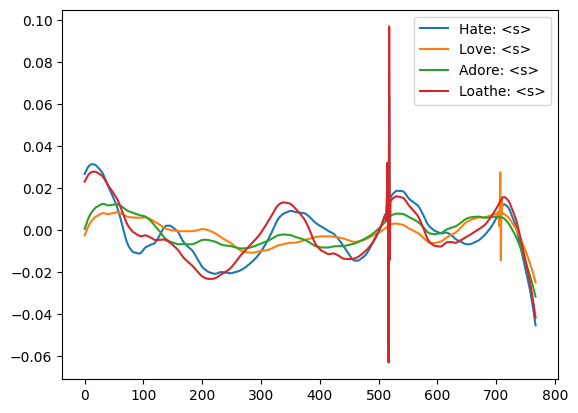

Score for Hate and Adore: 0.6893770694732666


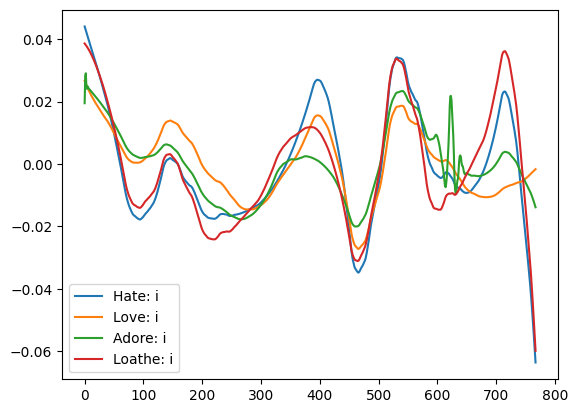

Score for Hate and Adore: 0.747462809085846


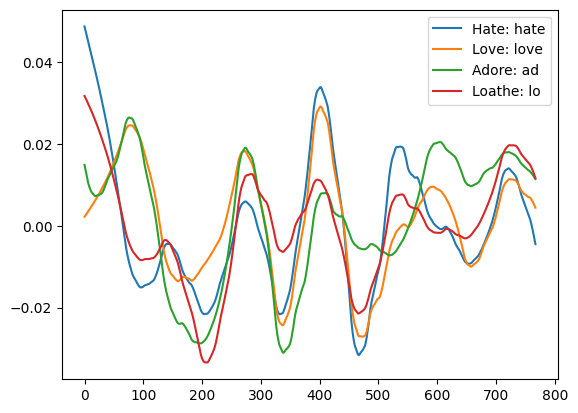

Score for Hate and Adore: 0.5391806960105896


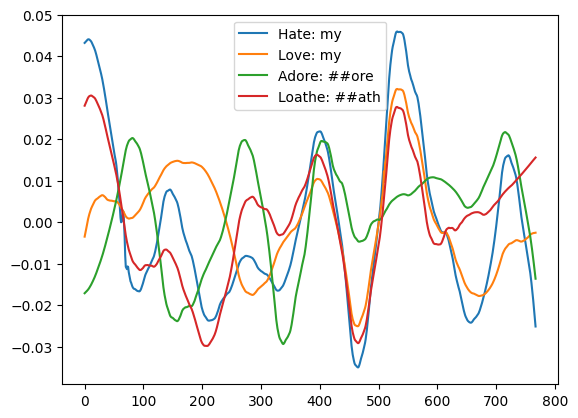

Score for Hate and Adore: 0.37048864364624023


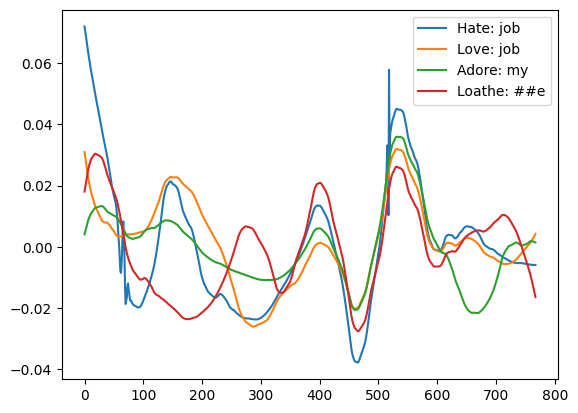

Score for Hate and Adore: 0.6372244954109192


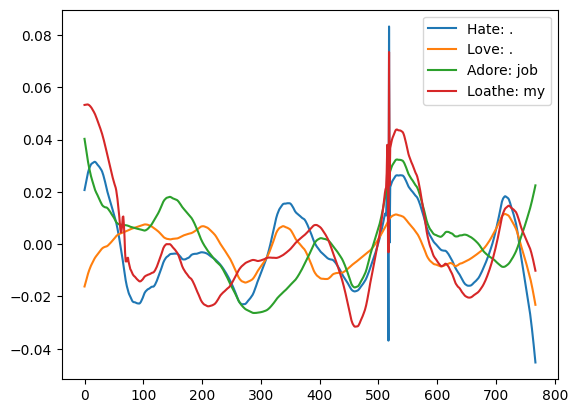

Score for Hate and Adore: 0.4649764895439148


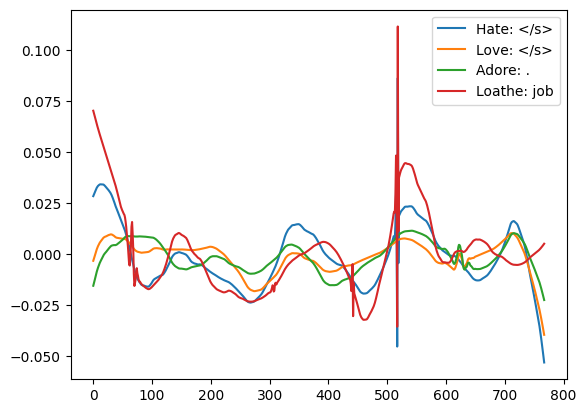

Score for Hate and Adore: 0.6031880378723145


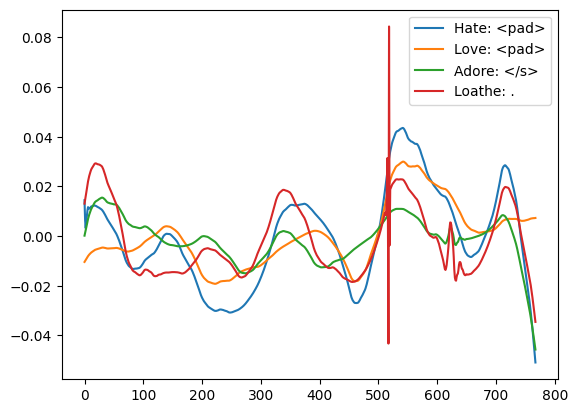

Score for Hate and Adore: 0.5132595300674438


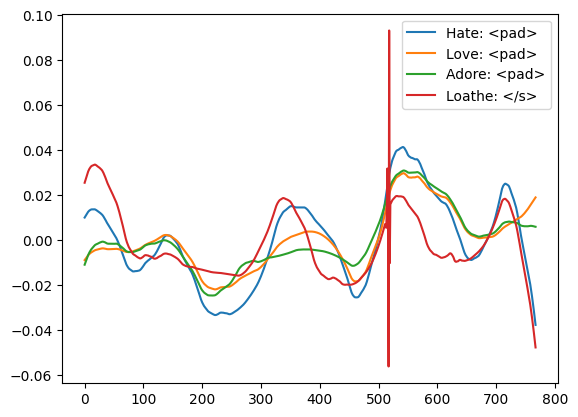

Score for Hate and Adore: 0.7997512221336365


In [109]:
embed_len = len(sent_lib_embeds[0][0])
param_x = np.arange(embed_len)

def get_label(num):
    if num == 0:
        return "Hate"
    elif num == 1:
        return "Love"
    elif num == 2:
        return "Adore"
    elif num == 3:
        return "Loathe"
    return None

for i in range(len(sent_lib_embeds[0])):
    for j in range(len(sent_lib_embeds)):
        plt.plot(param_x, proc.denoise(sent_lib_embeds[j, i]), label=f"{get_label(j)}: {tokens[j][i]}")
    plt.legend()
    plt.show()
    print(f"Score for {get_label(0)} and {get_label(2)}: {util.cos_sim(sent_lib_embeds[0][i], sent_lib_embeds[2][i])[0][0]}")




